In [1]:
from jax import config

# Double precision is highly recommended.
config.update("jax_enable_x64", True)

from jax import jit
from jax import lax
from jax import nn
from jax import numpy as jnp
from jax import random
from jax import scipy
from jax import value_and_grad
from jax import vmap

import matplotlib.pyplot as plt
import optax

from bojax.optimization import acquisitions, maximizers, spaces
from bojax.prediction import bijectors, kernels, means
from bojax.prediction.processes import gaussian

In [2]:
SEED = 0
LOWER_BOUND = -5
UPPER_BOUND = 5
NOISE = 1e-4
LEARNING_RATE = 0.01
NUM_QUERIES = 10

In [3]:
def objective(x):
    return -((x[..., 0] + 1) ** 2) * jnp.sin(2 * x[..., 0] + 2) / 5 + 1

In [4]:
x_test = jnp.linspace(LOWER_BOUND, UPPER_BOUND, 501)[..., jnp.newaxis]
y_test = objective(x_test)

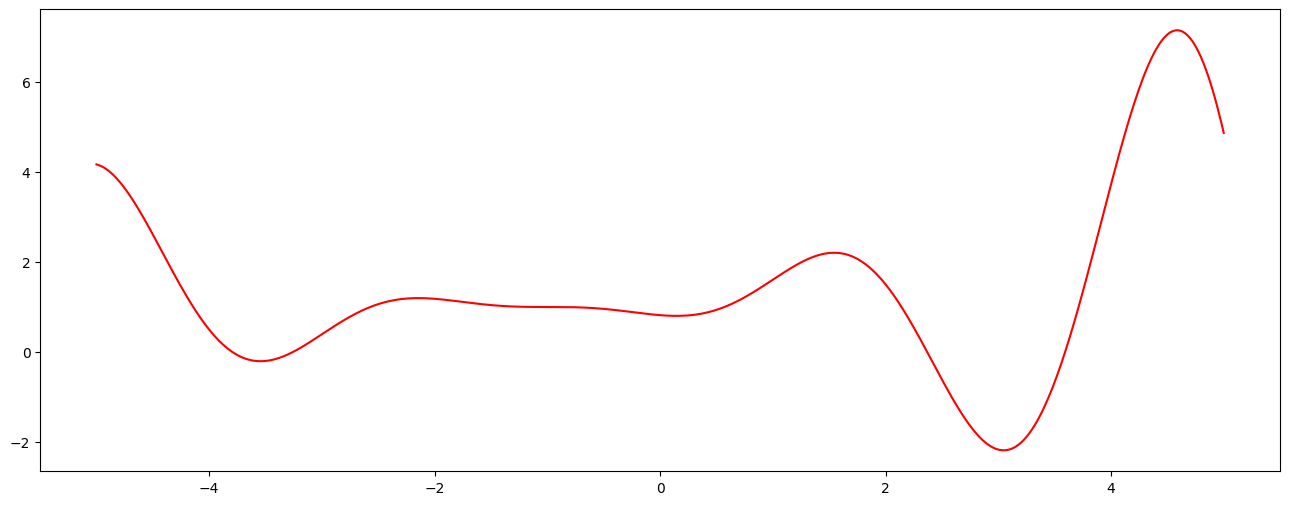

In [5]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(x_test, y_test, color='red', label='objective')

plt.show()

In [6]:
bijector = bijectors.softplus()

In [7]:
def prior(params):
    return gaussian.prior(
        vmap(means.constant(params['constant'])),
        vmap(vmap(kernels.scale(bijector.forward(params['amplitude']), kernels.matern_five_halves(bijector.forward(params['length_scale']))), in_axes=(None, 0)), in_axes=(0, None)),
        NOISE,
    )

def posterior(params, x_train, y_train):
    return gaussian.posterior(
        x_train,
        y_train,
        vmap(means.constant(params['constant'])),
        vmap(vmap(kernels.scale(bijector.forward(params['amplitude']), kernels.matern_five_halves(bijector.forward(params['length_scale']))), in_axes=(None, 0)), in_axes=(0, None)),
        NOISE,
    )

def fit(params, opt_state, x_train, y_train, num_iterations):
    def train_step(state, iteration):
        def loss_fn(params):            
            loc, scale = prior(params)(x_train)
            return -scipy.stats.multivariate_normal.logpdf(y_train, loc, scale)

        loss, grads = value_and_grad(loss_fn)(state[0])
        updates, opt_state = optimizer.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)

        return (params, opt_state), loss

    return lax.scan(
        jit(train_step),
        (params, opt_state),
        jnp.arange(num_iterations)
    )

def score(params, acquisition):
    return maximizers.bfgs(50)(
        jit(acquisition),
        spaces.continuous(jnp.array([[LOWER_BOUND, UPPER_BOUND]]))
    )

In [8]:
def show(x_train, y_train, x_test, y_test, x_next, mean, scale, scores):
    fig, axs = plt.subplots(2, 1, figsize=(16, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Prediction
    axs[0].set_ylabel('Predictive')
    axs[0].plot(x_test, y_test, color='red', label='objective')
    axs[0].scatter(x_train, y_train, color='black', marker='x', label='observations')
    axs[0].plot(x_test, mean, color='blue', label='mean')
    axs[0].fill_between(x_test.flatten(), mean - 2 * scale, mean + 2 * scale, alpha=0.3, label='95% CI')
    axs[0].axvline(x_next, linestyle='dotted', color='black')
    axs[0].legend()

    # Acquisition Score
    axs[1].set_ylabel('Acquisition score')
    axs[1].plot(x_test, scores, color='green')
    axs[1].fill_between(x_test.flatten(), scores, 0, color='green', alpha=0.5)
    axs[1].axvline(x_next, linestyle='dotted', color='black')

    plt.show()

In [9]:
params = {
    'constant': jnp.zeros(()),
    'amplitude': jnp.zeros(()),
    'length_scale': jnp.zeros(()),
}

In [10]:
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(params)

In [11]:
x_train = jnp.array([[1.0], [2.0]])
y_train = objective(x_train)

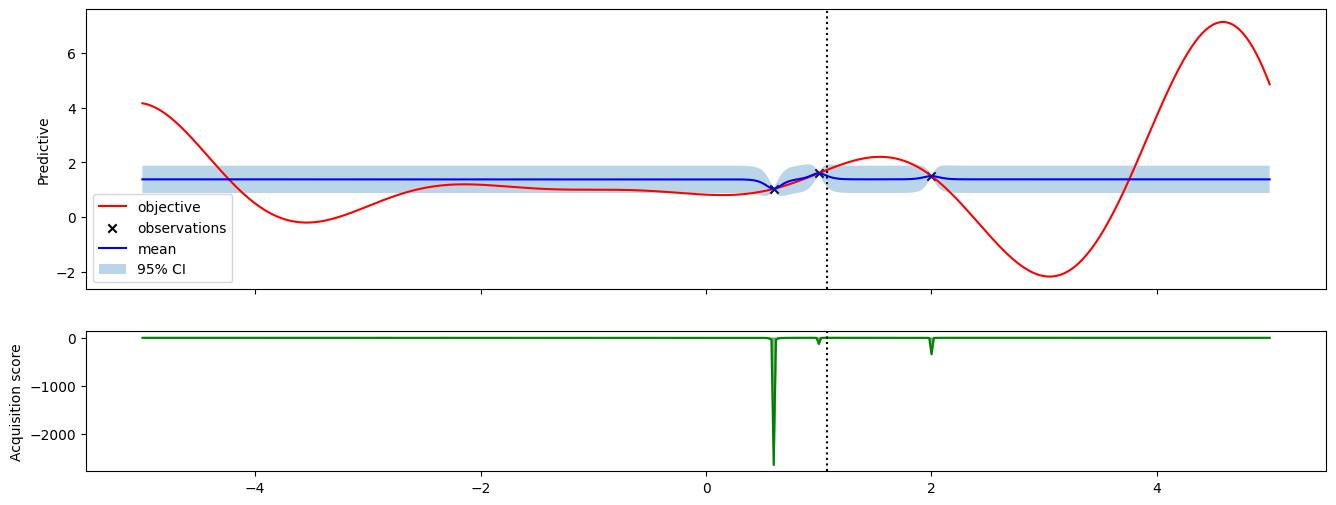

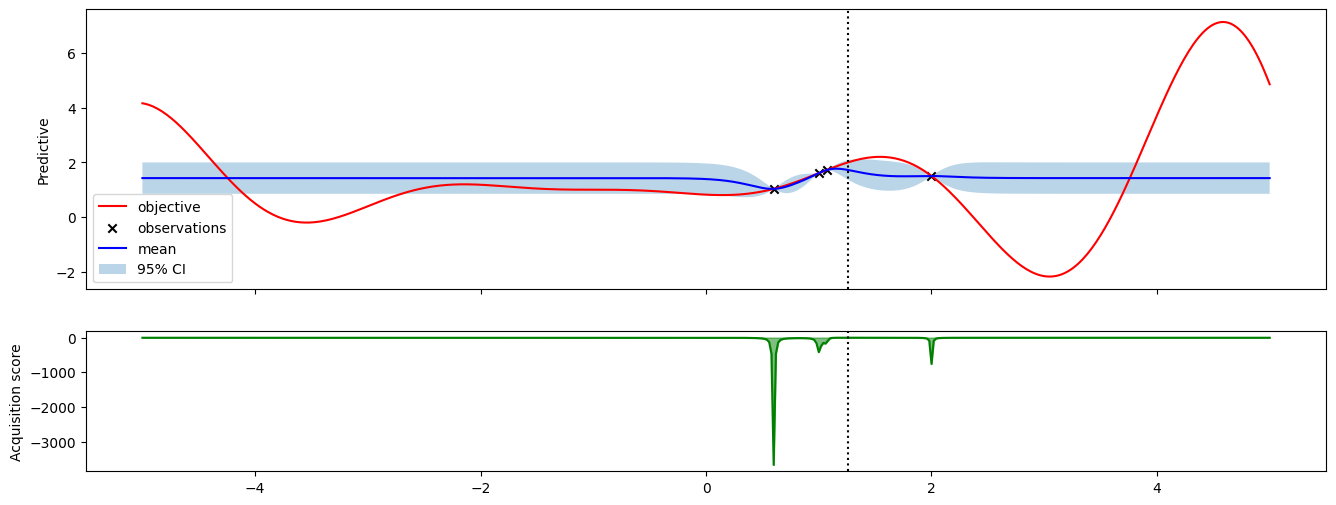

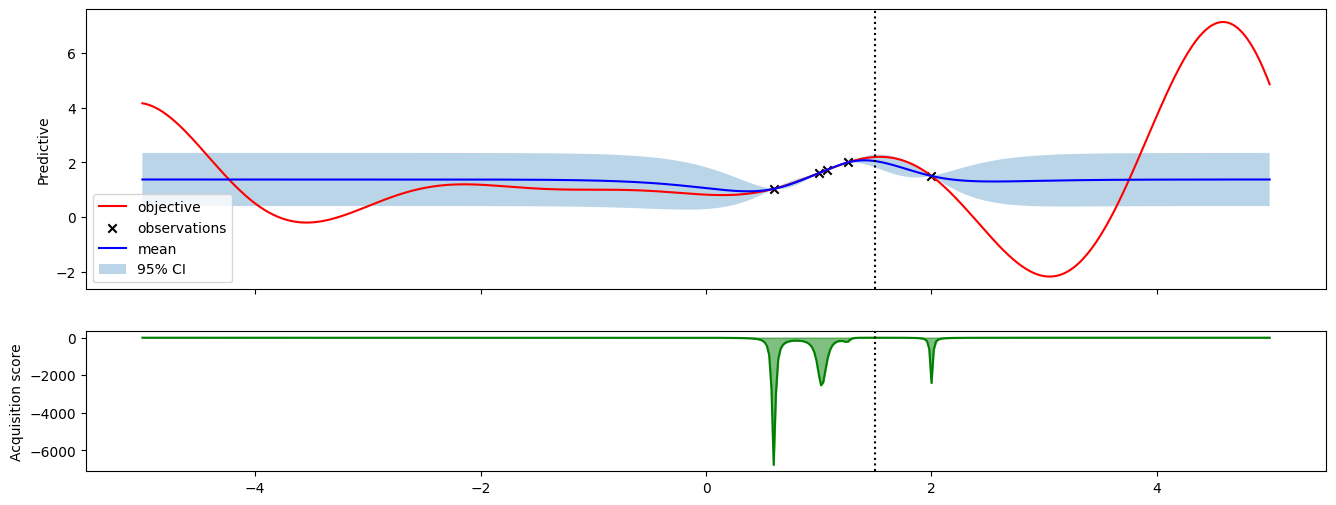

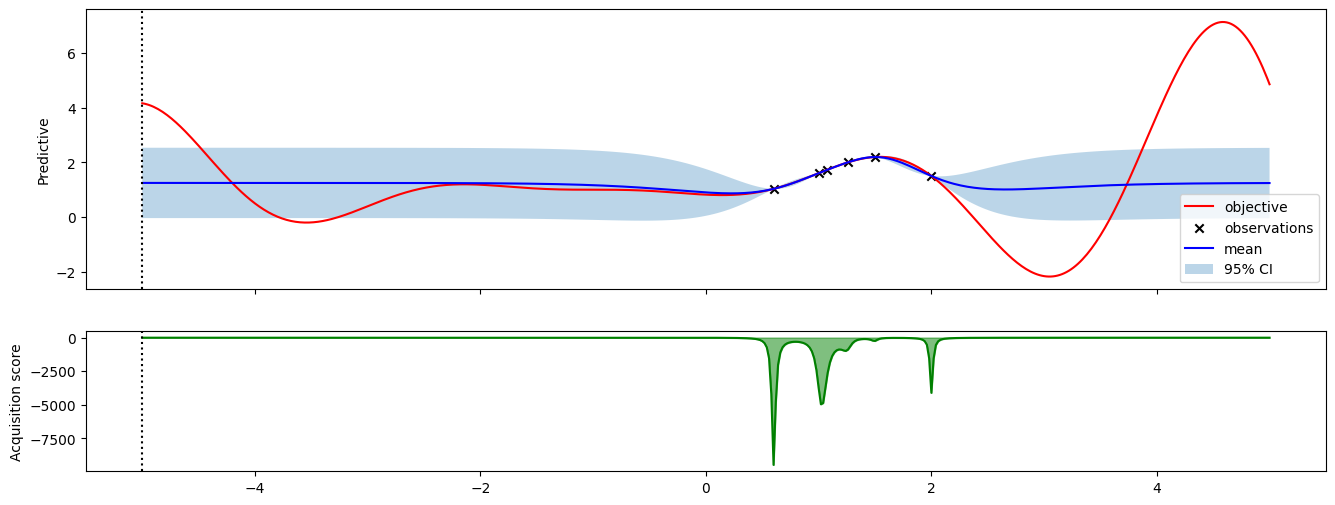

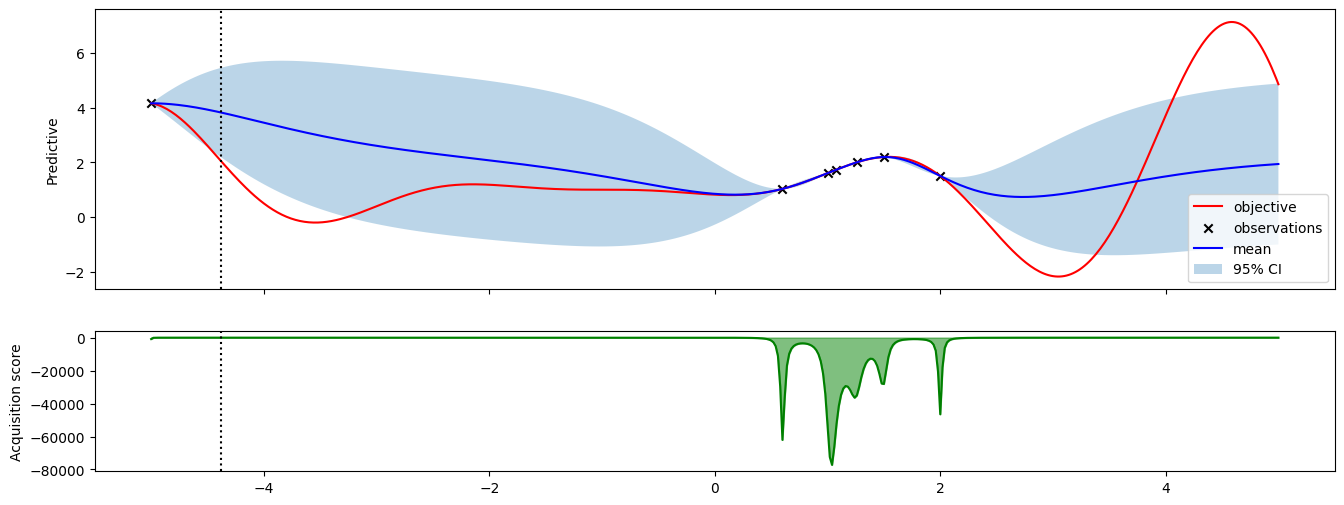

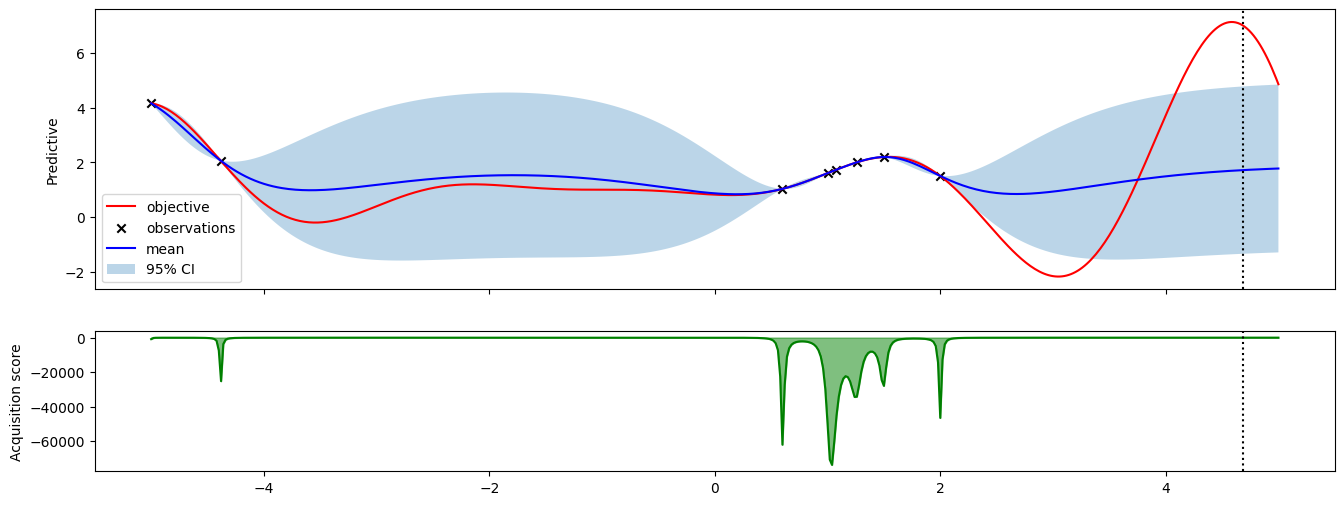

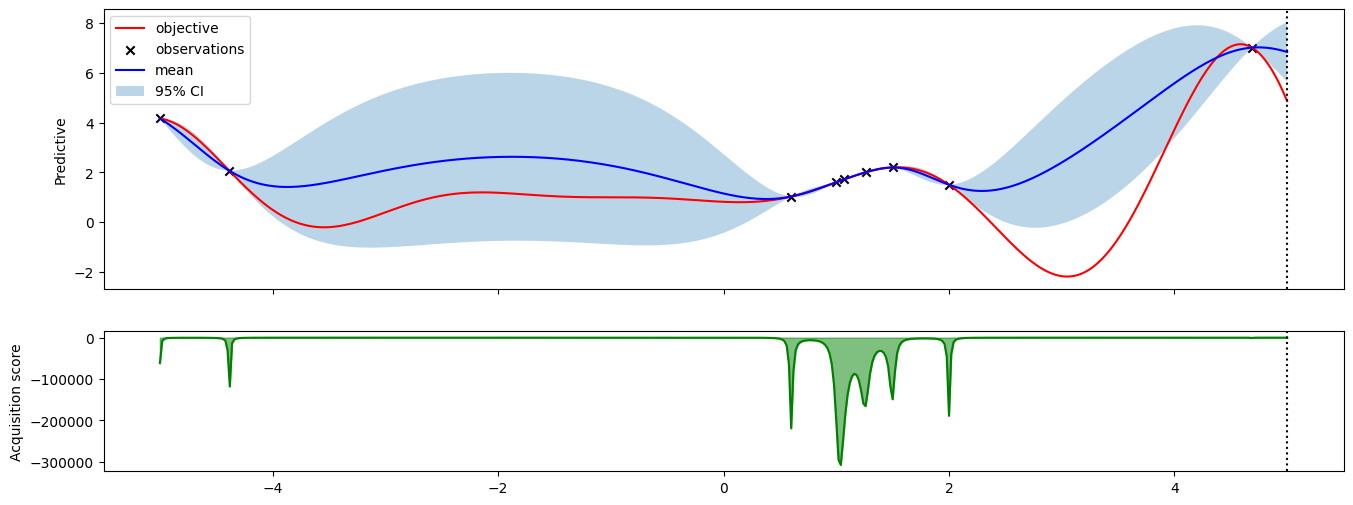

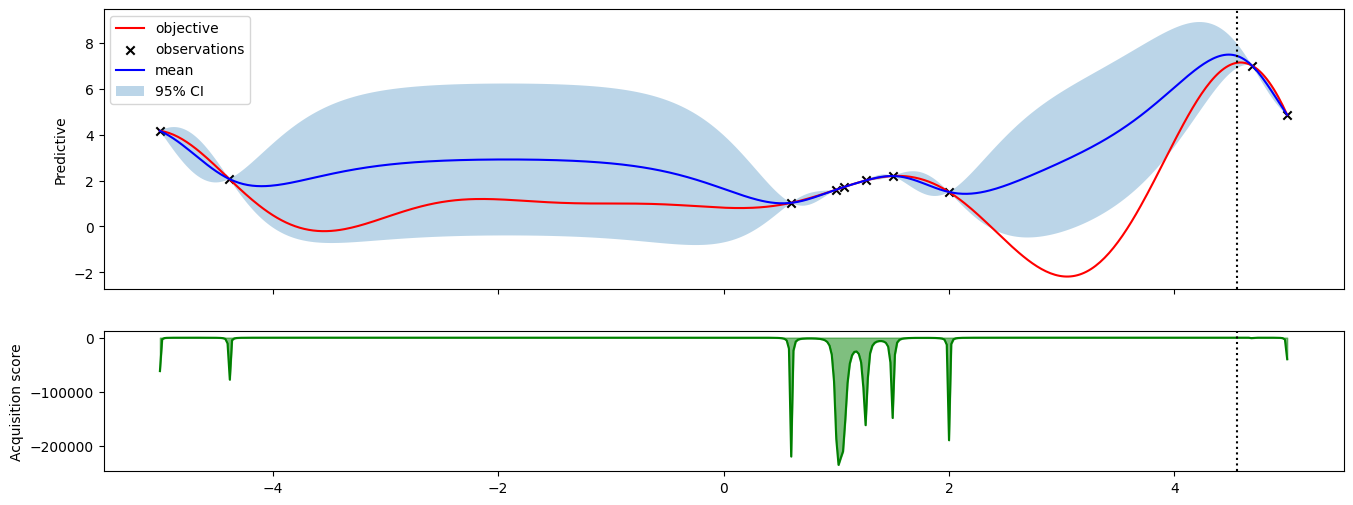

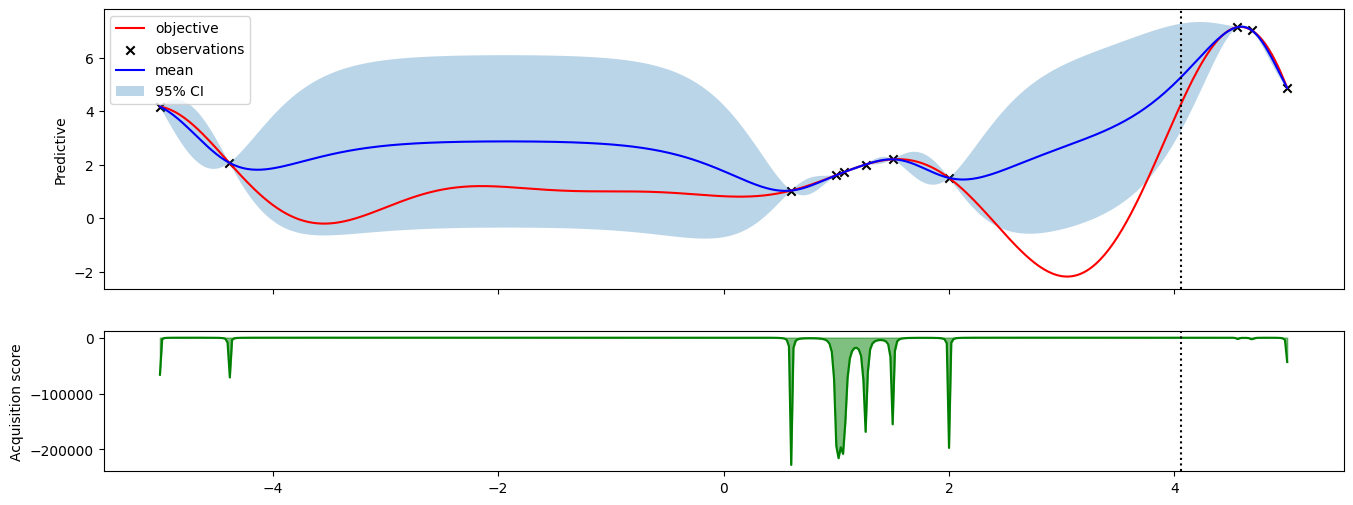

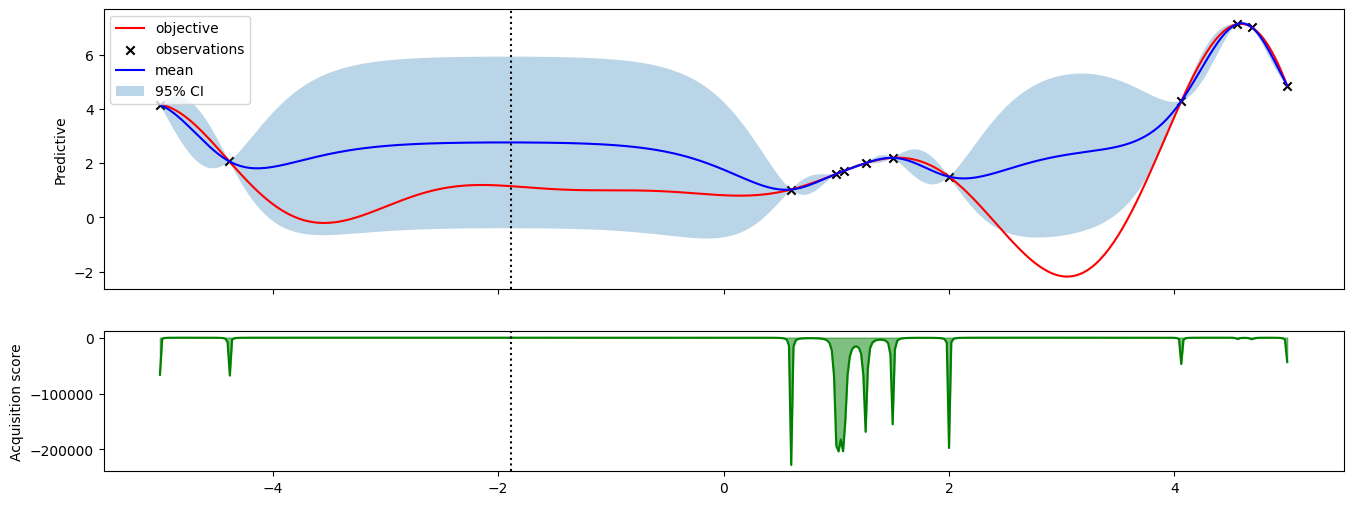

In [13]:
for i in range(NUM_QUERIES):
    (next_params, next_opt_state), history = fit(params, opt_state, x_train, y_train, 1000)
    
    process = posterior(next_params, x_train, y_train)
    mean, cov = process(x_test)
    scale = jnp.sqrt(jnp.diag(cov))

    acquisition = acquisitions.log_probability_of_improvement(jnp.max(y_train) * 1.1, process)
    scores = acquisition(x_test)
    
    candidates, values = score(next_params, acquisition)
    
    x_next = candidates[jnp.argmax(values), jnp.newaxis]
    y_next = objective(x_next)

    show(x_train, y_train, x_test, y_test, x_next, mean, scale, scores)

    x_train = jnp.vstack([x_train, x_next])
    y_train = jnp.hstack([y_train, y_next])